# LLMs

In [1]:
import sys
sys.path.append("..")
from src.Eval import eval_llm

import os
import io
from contextlib import redirect_stdout

def parse_filename(filename):
    parts = filename.split("_")
    dataset = parts[0]
    k_shot = parts[1].split(".")[0]
    k = int(k_shot.replace("shot", ""))
    return dataset, k

def silent_eval_llm(fpath):
    with io.StringIO() as buf, redirect_stdout(buf):
        # Call the actual eval_llm function
        return eval_llm(fpath)
    
def aggregated_results_llm(
    results_dir,
    ent_types=["overall", "Artist", "WoA"],
    eval_schemas=["strict", "exact", "ent_type"],
    metrics=["f1", "f1_macro", "precision", "precision_macro", "recall", "recall_macro", "missed", "spurious", "incorrect"],
    datasets=["dataset1", "dataset2", "dataset3", "dataset4"],
    ks=[0,5,15,25,35,45]
):
    results = {}
    for metric in metrics:
        results[metric] = {}
        for schema in eval_schemas:
            results[metric][schema] = {}
            for ent_type in ent_types:
                results[metric][schema][ent_type] = {}
                for model in [m for m in os.listdir(results_dir) if m != "archive"]:
                    results[metric][schema][ent_type][model] = {}
                    for k in ks:
                        results[metric][schema][ent_type][model][k] = []

    model_dirs = [
        os.path.join(results_dir, d)
        for d in os.listdir(results_dir)
        if os.path.isdir(os.path.join(results_dir, d)) and d != "archive"
    ]

    for model_dir in model_dirs:
        model = model_dir.split(os.sep)[-1]
        files = [
            os.path.join(model_dir, f)
            for f in os.listdir(model_dir)
            if os.path.isfile(os.path.join(model_dir, f))
        ]

        for fpath in files:
            filename = os.path.basename(fpath)
            dataset, k = parse_filename(filename)

            if dataset in datasets and k in ks:
                predictions = silent_eval_llm(fpath)

                for ent_type in ent_types:
                    for schema in eval_schemas:
                        for metric in metrics:
                            key = f"{ent_type}_{schema}_{metric}"
                            if key in predictions.keys():
                                results[metric][schema][ent_type][model][k].append(predictions[key])
    return results

results_rand = aggregated_results_llm("../output/rand_sampling")
results_tfidf = aggregated_results_llm("../output/tfidf_sampling")


2024-09-23 13:49:27 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:27 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:27 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:27 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:28 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:28 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:28 root INFO: Imported 751 predictions for 751 true examples
2024-09-23 13:49:28 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:29 root INFO: Imported 751 predictions for 751 true examples
2024-09-23 13:49:29 root INFO: Imported 751 predictions for 751 true examples
2024-09-23 13:49:29 root INFO: Imported 751 predictions for 751 true examples
2024-09-23 13:49:29 root INFO: Imported 600 predictions for 600 true examples
2024-09-23 13:49:29 root INFO: Imported 600 predictions for 600 

In [22]:
import pandas as pd
import numpy as np

def results_to_dataframe(aggregated_results, metric, agg_func='mean'):
    data = []

    for schema, schema_dict in aggregated_results[metric].items():
        for ent_type, ent_type_dict in schema_dict.items():
            for model, model_dict in ent_type_dict.items():
                for k_shot, values in model_dict.items():
                    func = np.mean if agg_func == 'mean' else 'sum'
                    if values:
                        agg_value = func(values)
                        
                        data.append([schema, ent_type, model, k_shot, agg_value])                        
                    if k_shot == 5: # copy zeroshot
                        values = results_rand[metric][schema][ent_type][model][0]
                        agg_value = func(values)
                        data.append([schema, ent_type, model, 0, agg_value])                        

    df = pd.DataFrame(data, columns=['Schema', 'Entity Type', 'Model', 'k', 'Value'])
    df.Model = df.Model.str.replace("mistral", "Mistral-7B").str.replace("mixtral", "Mixtral-8x7B").str.replace("gpt-3.5-turbo-0125", "GPT-3.5-Turbo")
    return df.set_index(["Schema", "Entity Type", "Model", "k"])

results_to_dataframe(results_tfidf, "precision", "mean").reset_index()


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Schema,Entity Type,Model,k,Value
0,strict,overall,Mistral-7B,0,NaN
1,strict,overall,GPT-3.5-Turbo,0,NaN
2,strict,overall,Mixtral-8x7B,0,NaN
3,strict,Artist,Mistral-7B,5,0.712736
4,strict,Artist,Mistral-7B,0,0.583409
...,...,...,...,...,...
112,ent_type,WoA,Mixtral-8x7B,0,0.910287
113,ent_type,WoA,Mixtral-8x7B,15,0.834984
114,ent_type,WoA,Mixtral-8x7B,25,0.820656
115,ent_type,WoA,Mixtral-8x7B,35,0.834831


# Precision 

In [23]:
results = results_to_dataframe(results_tfidf, "precision", "mean").reset_index()
results[(results.Schema == "strict") & (results.k == 35)].drop(["Schema", "k"], axis=1)



/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Entity Type,Model,Value
7,Artist,Mistral-7B,0.777103
13,Artist,GPT-3.5-Turbo,0.907031
19,Artist,Mixtral-8x7B,0.889135
25,WoA,Mistral-7B,0.736221
31,WoA,GPT-3.5-Turbo,0.636991
37,WoA,Mixtral-8x7B,0.765298


# Recall

In [24]:
results = results_to_dataframe(results_tfidf, "recall", "mean").reset_index()
results[(results.Schema == "strict") & (results.k == 35)].drop(["Schema", "k"], axis=1)



/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Entity Type,Model,Value
7,Artist,Mistral-7B,0.705581
13,Artist,GPT-3.5-Turbo,0.781502
19,Artist,Mixtral-8x7B,0.776952
25,WoA,Mistral-7B,0.607756
31,WoA,GPT-3.5-Turbo,0.649343
37,WoA,Mixtral-8x7B,0.721376


In [25]:
results_to_dataframe(results_tfidf, "f1_macro", "mean")


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Value
Schema   Entity Type Model         k           
strict   overall     Mistral-7B    5   0.647793
                                   0   0.494126
                                   15  0.703132
                                   25  0.719543
                                   35  0.702602
...                                         ...
ent_type Artist      GPT-3.5-Turbo 0        NaN
                     Mixtral-8x7B  0        NaN
         WoA         Mistral-7B    0        NaN
                     GPT-3.5-Turbo 0        NaN
                     Mixtral-8x7B  0        NaN

[72 rows x 1 columns]

# Figure: F1 Scores with Strict Evaluation

/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

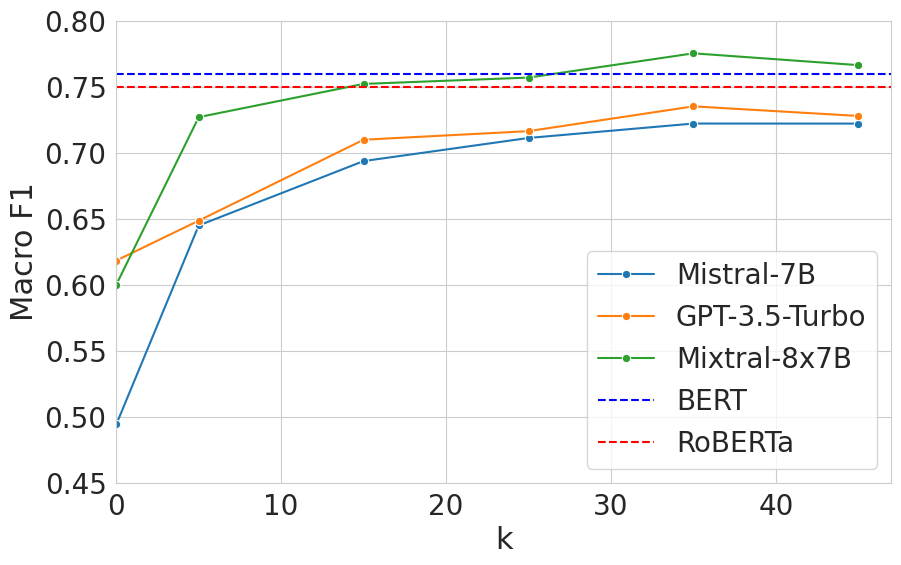

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
df_results = results_to_dataframe(results_rand, "f1_macro", "mean")
df_results = df_results[df_results.index.get_level_values('Model') != 'llama3']

df_plot = df_results.loc["strict"].loc["overall"]

# Create the Seaborn plot
plt.rcParams.update({'xtick.labelsize': 20, 'ytick.labelsize': 20})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='k', y='Value', hue='Model', marker='o')

# Add horizontal lines at specific values (e.g., 0.75 and 0.78)
f1_scores = [0.76, 0.75]
colors = ['b', 'r']  # Colors for the lines
baselines = ["BERT", "RoBERTa"]

for value, color, model in zip(f1_scores, colors, baselines):
    plt.axhline(y=value, color=color, linestyle='--', label=model)

# Create custom legend entries for the horizontal lines
handles, labels = plt.gca().get_legend_handles_labels()
for value, color, model in zip(f1_scores, colors, baselines):
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--'))
    labels.append(model)

plt.legend(handles=handles, title='Model')

#plt.title('Values by k and Model')
plt.xlabel('k', fontsize=22)
plt.ylabel('Macro F1', fontsize=22)
plt.xlim((0,47))
plt.ylim((0.45,0.8))
plt.legend(fontsize=20)
plt.savefig("../figures/rand_strict_overall.pdf")
plt.show()


In [18]:
results_rand

{'f1': {'strict': {'overall': {'mistral': {0: [],
     5: [],
     15: [],
     25: [],
     35: [],
     45: []},
    'llama3': {0: [], 5: [], 15: [], 25: [], 35: [], 45: []},
    'gpt-3.5-turbo-0125': {0: [], 5: [], 15: [], 25: [], 35: [], 45: []},
    'mixtral': {0: [], 5: [], 15: [], 25: [], 35: [], 45: []}},
   'Artist': {'mistral': {0: [0.5874499332443257,
      0.5901116427432216,
      0.5601317957166392,
      0.6185567010309277],
     5: [0.6777777777777778,
      0.7302158273381295,
      0.7055476529160739,
      0.7021696252465485],
     15: [0.7276190476190476,
      0.7422096317280453,
      0.7734806629834253,
      0.7661141804788213],
     25: [0.7293127629733519,
      0.7490774907749076,
      0.7450980392156863,
      0.8029739776951672],
     35: [0.7955390334572491,
      0.7527272727272728,
      0.7640449438202247,
      0.7758007117437722],
     45: [0.7771836007130124,
      0.8117001828153564,
      0.7733812949640289,
      0.7724137931034483]},
    'llama3

/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

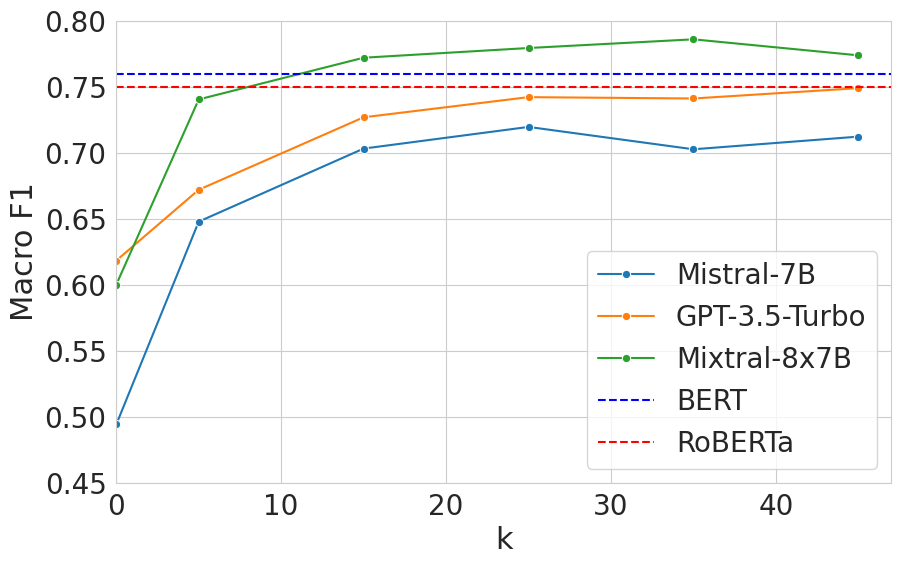

In [27]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
df_results = results_to_dataframe(results_tfidf, "f1_macro", "mean")

df_results = df_results[df_results.index.get_level_values('Model') != 'llama3']

df_plot = df_results.loc["strict"].loc["overall"]

# Create the Seaborn plot
plt.rcParams.update({'xtick.labelsize': 20, 'ytick.labelsize': 20})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot, x='k', y='Value', hue='Model', marker='o')

# Add horizontal lines at specific values (e.g., 0.75 and 0.78)
f1_scores = [0.76, 0.75]
colors = ['b', 'r']  # Colors for the lines
baselines = ["BERT", "RoBERTa"]

for value, color, model in zip(f1_scores, colors, baselines):
    plt.axhline(y=value, color=color, linestyle='--', label=model)

# Create custom legend entries for the horizontal lines
handles, labels = plt.gca().get_legend_handles_labels()
for value, color, model in zip(f1_scores, colors, baselines):
    handles.append(plt.Line2D([0], [0], color=color, linestyle='--'))
    labels.append(model)

plt.legend(handles=handles, title='Model')

#plt.title('Values by k and Model')
plt.xlabel('k', fontsize=22)
plt.ylabel('Macro F1', fontsize=22)
plt.xlim((0,47))
plt.ylim((0.45,0.8))
plt.legend(fontsize=20)
plt.savefig("../figures/tfidf_strict_overall.pdf")
plt.show()


# Baseline: BERT etc.

In [20]:
import importlib
sys.path.append('../baseline/music-ner-eacl2023/music-ner/tables-and-stats')
transformer_baselines = importlib.import_module("transformer_baselines")
from transformer_baselines import model_results, print_latex_table

print_latex_table(model_results(
    "../baseline/music-ner-eacl2023/output/", 
    ["bert-large-uncased", "roberta-large", "mpnet-base"]))


FileNotFoundError: [Errno 2] No such file or directory: '../baseline/music-ner-eacl2023/output/shs100k2/bert-large-uncased/predict_results.json'

In [19]:
import sys
sys.path.append("..")
from src.Eval import compute_results_jsonl, compute_results_txt
from src.Utils import get_true_pred_entities, read_IOB_file
from baseline.parse_output import get_results_overall_table, get_results_table, parse_preds_baseline

BASELINES = ["bert-large-uncased", "roberta-large", "mpnet-base"]
OUTPUT_PATH_REDDIT = "../baseline/music-ner-eacl2023/output/dataset"

results_f1 = get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(1)).loc["macro", "strict", "f1"]
for i in range(2,5):
    results_f1 += get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i)).loc["macro", "strict", "f1"]
results_f1 =  results_f1/4
results_f1


Model
bert-large-uncased    0.768363
mpnet-base            0.789229
roberta-large         0.768811
Name: (macro, strict, f1), dtype: float64

In [21]:


results_attrs = get_results_table(BASELINES, OUTPUT_PATH_REDDIT + str(1))
for i in range(2,5):
    results_attrs += get_results_table(BASELINES, OUTPUT_PATH_REDDIT + str(1))
results_attrs =  results_attrs/4
results_attrs


f1                                          \
Attribute             Artist                           WoA             
Scenario               exact    strict      type     exact    strict   
Model                                                                  
bert-large-uncased  0.840909  0.795455  0.821429  0.779582  0.751740   
mpnet-base          0.858097  0.801336  0.838063  0.813239  0.784870   
roberta-large       0.833063  0.764992  0.794165  0.799054  0.747045   

                             precision                                \
Attribute                       Artist                           WoA   
Scenario                type     exact    strict      type     exact   
Model                                                                  
bert-large-uncased  0.807425  0.827476  0.782748  0.808307  0.753363   
mpnet-base          0.841608  0.868243  0.810811  0.847973  0.800000   
roberta-large       0.827423  0.818471  0.751592  0.780255  0.786047   

                                          recall                      \
Attribute                                 Artist                       
Scenario              strict      type     exact    strict      type   
Model                                                                  
bert-large-uncased  0.726457  0.780269  0.854785  0.808581  0.834983   
mpnet-base          0.772093  0.827907  0.848185  0.792079  0.828383   
roberta-large       0.734884  0.813953  0.848185  0.778878  0.808581   

                                                  
Attribute                WoA                      
Scenario               exact    strict      type  
Model                                             
bert-large-uncased  0.807692  0.778846  0.836538  
mpnet-base          0.826923  0.798077  0.855769  
roberta-large       0.812500  0.759615  0.841346

In [22]:
get_mean_results(BASELINES, OUTPUT_PATH_REDDIT, eval_scheme="strict", metric="precision")

NameError: name 'get_mean_results' is not defined

In [23]:
get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i)).loc["macro", "strict", "f1"] + get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i-1)).loc["macro", "strict", "f1"]


Model
bert-large-uncased    1.513513
mpnet-base            1.551976
roberta-large         1.526992
Name: (macro, strict, f1), dtype: float64

In [24]:
get_results_overall_table(BASELINES, OUTPUT_PATH_REDDIT + str(i))


Model                     bert-large-uncased  mpnet-base  roberta-large
      Scenario Metric                                                  
macro exact    actual             340.000000  325.000000     317.000000
               correct            267.500000  261.500000     259.000000
               f1                   0.799376    0.794925       0.801200
               incorrect           16.000000   16.500000      17.500000
               missed              43.000000   48.500000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.782272    0.796725       0.812858
               recall               0.817542    0.793134       0.789885
               spurious            56.500000   47.000000      40.500000
      strict   actual             340.000000  325.000000     317.000000
               correct            247.000000  245.500000     240.000000
               f1                   0.734035    0.744845       0.736574
               incorrect           36.500000   32.500000      36.500000
               missed              43.000000   48.500000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.718656    0.746534       0.747400
               recall               0.750358    0.743163       0.726071
               spurious            56.500000   47.000000      40.500000
      type     actual             340.000000  325.000000     317.000000
               correct            263.000000  262.000000     257.500000
               f1                   0.783797    0.801152       0.795037
               incorrect           20.500000   16.000000      19.000000
               missed              43.000000   48.500000      50.000000
               partial              0.000000    0.000000       0.000000
               possible           326.500000  326.500000     326.500000
               precision            0.767197    0.802954       0.806634
               recall               0.801422    0.799357       0.783783
               spurious            56.500000   47.000000      40.500000
micro exact    actual             680.000000  650.000000     634.000000
               correct            535.000000  523.000000     518.000000
               f1                   0.802701    0.802763       0.804973
               incorrect           32.000000   33.000000      35.000000
               missed              86.000000   97.000000     100.000000
               partial              0.000000    0.000000       0.000000
               possible           653.000000  653.000000     653.000000
               precision            0.786765    0.804615       0.817035
               recall               0.819296    0.800919       0.793262
               spurious           113.000000   94.000000      81.000000
      strict   actual             680.000000  650.000000     634.000000
               correct            494.000000  491.000000     480.000000
               f1                   0.741185    0.753645       0.745921
               incorrect           73.000000   65.000000      73.000000
               missed              86.000000   97.000000     100.000000
               partial              0.000000    0.000000       0.000000
               possible           653.000000  653.000000     653.000000
               precision            0.726471    0.755385       0.757098
               recall               0.756508    0.751914       0.735069
               spurious           113.000000   94.000000      81.000000
      type     actual             680.000000  650.000000     634.000000
               correct            526.000000  524.000000     515.000000
               f1                   0.789197    0.804298       0.800311
               incorrect           41.00

### Takeaways from Overall
- at least for few-shot, BERT-like models seem to be better than LLaMa-3

# Error Analysis
### BERT on Dataset4

In [25]:
data = get_true_pred_entities(
    "bert-large-uncased", "../baseline/music-ner-eacl2023/output/dataset" + str(4)).dropna(
        how="all")

mask_artist = (data.Artist_true != data.Artist_pred) & ~(data.Artist_true.isna() & data.Artist_pred.isna())
mask_woa = (data.WoA_true != data.WoA_pred) & ~(data.WoA_true.isna() & data.WoA_pred.isna())

data.loc[(mask_woa | mask_artist), 
         ["text", "WoA_true", "WoA_pred", "Artist_true", "Artist_pred"]
         ].sample(frac=1).to_csv("../output/reddit/error_analysis/d4.csv")


OSError: Cannot save file into a non-existent directory: '../output/reddit/error_analysis'

##### Errors at WoA

##### Errors at Artist

# Ideas
### Stabilize
- Always: "Does the entity X refer to a Work of Art or a musical Artist?"
- If no entity found: "Is there no entity referring to a Work of Art (WoA) or a musical Artist?"
### Understandability
- If there is a WoA in this text, how did you identify it?
- If there is an Artist in this text, how did you identify it?
- Did you use linguistic knowledge to identify entities or did you 
